In [3]:
!pip install -q --progress-bar off numpy pandas matplotlib statsmodels

In [5]:
import pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [6]:
csv_file = "section_pc.csv.zip"

In [ ]:
!wget https://jirkabalhar.cz/bazos/$csv_file

In [7]:
df = pandas.read_csv(csv_file)
print(f"Loaded {len(df)} rows")

Loaded 1270181 rows


In [8]:
def search(df, keywords=[], filter_keywords=[], price_lower=None, price_upper=None, unique=False, lowercase=True):
    """
    Searches the dataframe for the given keywords and price range.

    keywords may be:
    - a string, then this string must be present in the title
    - a list of strings, then all keywords must be present title in any order
    - a list of lists of strings, each top level list must be "satisfied" by having at least one element from each list present in the title (i.e. keyword presence is in Conjunctive Normal Form)

    filter_keywords may be:
    - a string, then this string must NOT be present in the title
    - a list of strings, then all of the keywords must NOT be present in the title
    - a list of lists of strings, each top level list must NOT be "satisfied" by having at least one element from each list present in the title

    price_lower is the lower price bound (smallest price allowed)
    price_upper is the upper price bound (largest price allowed)

    unique removes duplicate rows that have the same title and price
    lowercase makes the search case insensitive
    """
    df_filtered = df

    if price_lower is not None:
        df_filtered = df_filtered[(df_filtered.price >= price_lower)]
    if price_upper is not None:
        df_filtered = df_filtered[(df_filtered.price <= price_upper)]
    titl = df_filtered.title.str
    if lowercase:
        titl = titl.lower().str

    if type(keywords) == str:
        keywords = [keywords]

    if type(filter_keywords) == str:
        filter_keywords = [filter_keywords]
    
    keywords = [[k] if type(k) == str else k for k in keywords]
    if lowercase:
        keywords = [[kk.lower() for kk in k] for k in keywords]
    
    filter_keywords = [[k] if type(k) == str else k for k in filter_keywords]
    if lowercase:
        filter_keywords = [[kk.lower() for kk in k] for k in filter_keywords]
    
    def _create_query(kwords):
        query = titl.contains("")
        for k in kwords:
            contains = None
            for k_or in k:
                if contains is None:
                    contains = titl.contains(k_or)
                else:
                    contains = contains | titl.contains(k_or)

            if query is None:
                query = contains
            else:
                query = query & contains
        return query
    
    query = _create_query(keywords)
    if filter_keywords:
        query = query & (~_create_query(filter_keywords))
    df_filtered = df_filtered[query].sort_values("datetime")
    if unique:
        df_filtered = df_filtered.groupby(["title", "price"]).first().reset_index().sort_values("datetime")
    return df_filtered

def plot(res, title):
    res = res.sort_values("price").sort_values("datetime")
    res["timestamp"] = res["datetime"].apply(lambda x: x.timestamp())
    res["datetime"] = pandas.to_datetime(res["datetime"], utc=True)
    y_lowess = sm.nonparametric.lowess(res['price'], res['datetime'], frac = 0.20)  # 30 % lowess smoothing

    plt.plot(res['datetime'], res['price'], '.', alpha=0.6)
    plt.plot(pandas.to_datetime(y_lowess[:, 0]), y_lowess[:, 1])
    plt.title(title)
    plt.grid()
    ax = plt.gca()
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    plt.xlabel("Datum")
    plt.ylabel("Cena (Kč)")

In [9]:
pandas.options.display.max_rows = 10
pandas.options.display.min_rows = 10

In [10]:
res = search(df, [["gtx 1070"]], [["1070 ti", "1070ti", "intel", "i5", "i7", "ryzen", "herní", "počítač", "laptop", "pc", "notebook"]], price_lower=1300, price_upper=10000)

In [11]:
res

,title,price,price_string,link,datetime
1046119,Nvidia KFA GTX 1070 EX,7000.0,7 000,https://pc.bazos.cz/inzerat/151854632/nvidia-k...,2022-05-01 14:15:11+02:00
1046269,Grafická karta GTX 1070 8GB,5500.0,5 500,https://pc.bazos.cz/inzerat/151903235/graficka...,2022-05-02 13:34:40+02:00
1046362,3kusy Nvidia GTX 1070 8GB OC MINI,6899.0,6 899,https://pc.bazos.cz/inzerat/151940821/3kusy-nv...,2022-05-03 09:55:39+02:00
1046372,Gigabite GEFORCE GTX 1070 8Gb,6500.0,6 500,https://pc.bazos.cz/inzerat/151945908/gigabite...,2022-05-03 11:46:12+02:00
1046405,ASUS GTX 1070 DUAL 8GB GDDR5,6500.0,6 500,https://pc.bazos.cz/inzerat/151964194/asus-gtx...,2022-05-03 19:25:22+02:00
...,...,...,...,...,...
1229717,❰ Grafická karta | Asus ROG Strix Nvidia GTX 1...,3000.0,3 000,https://pc.bazos.cz/inzerat/188799160/graficka...,2024-07-25 17:07:52+02:00
1229744,ASUS GTX 1070 TURBO 8GB,2000.0,2 000,https://pc.bazos.cz/inzerat/188813603/asus-gtx...,2024-07-26 06:09:14+02:00
1229783,Palit GTX 1070 8GB Dual,2100.0,2 100,https://pc.bazos.cz/inzerat/188842059/palit-gt...,2024-07-26 17:22:40+02:00
1229928,gtx 1070 palit,1900.0,1 900,https://pc.bazos.cz/inzerat/188952466/gtx-1070...,2024-07-29 09:27:39+02:00


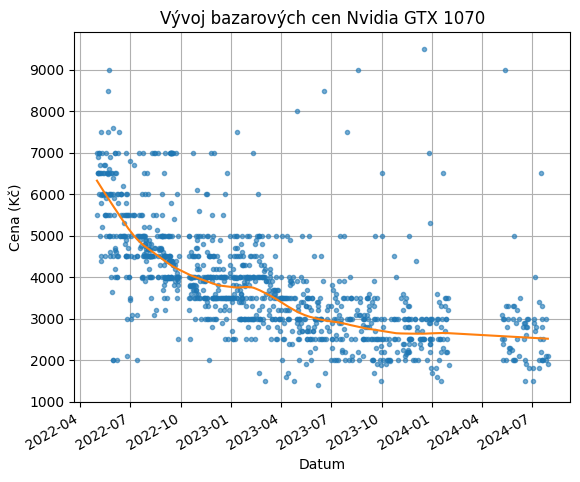

In [12]:
plot(res, "Vývoj bazarových cen Nvidia GTX 1070")

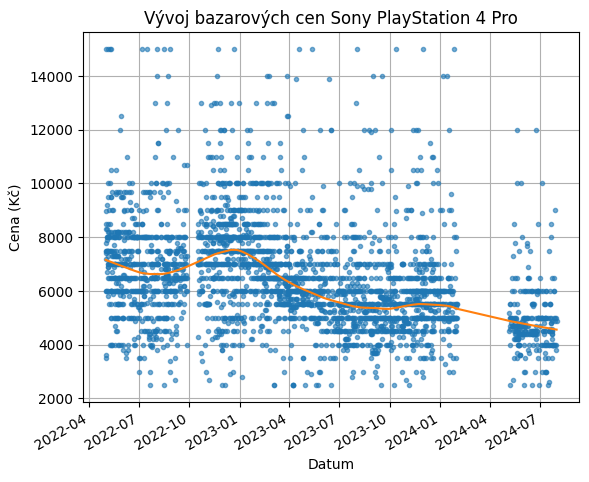

In [14]:
plot(search(df, ["ps4 pro"], [["slim", "fat"]], price_lower=2500, price_upper=15000), "Vývoj bazarových cen Sony PlayStation 4 Pro")

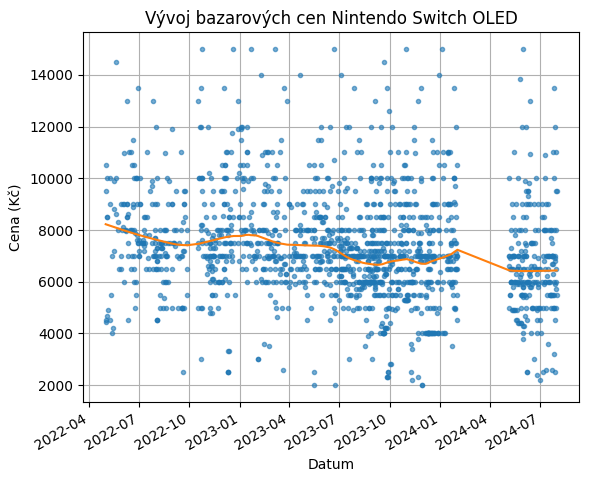

In [15]:
plot(search(df, ["nintendo", "switch", "oled"], [["lite"]], price_lower=2000, price_upper=15000), "Vývoj bazarových cen Nintendo Switch OLED")